## Implementing a GPT model from scratch to generate text
In this chapter **Sebastian** explains the code to implement the architecture of LLM that can be trained to generate human-like text.
The implementation includes normalized layer activations, shortcut connections, transformer blocks and, finally, the computation of the number of parameters and storage requirements of GPT models.  

In the previous chapter we imeplmented most of the component present in the architecture of LLM. Now, it's time to recreate the implementation of all the system and loading pretrained weights into our implementation. These weights are essentially the internal variables of the model that are essentiallu the internal variables of the model that are adjusted and optimized during the training process to minimize a specific loss function. 

**This optimization allows the model to learn from the training data** 



In [1]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.7
torch version: 2.9.0
tiktoken version: 0.12.0


#### GPT Backbone

Creating a Dummy implemntation which let us to understand how the archietcture is made up and how it is sequentially formed. Some blocks will be implemented step-by-step and the results will come from the union of different modules.

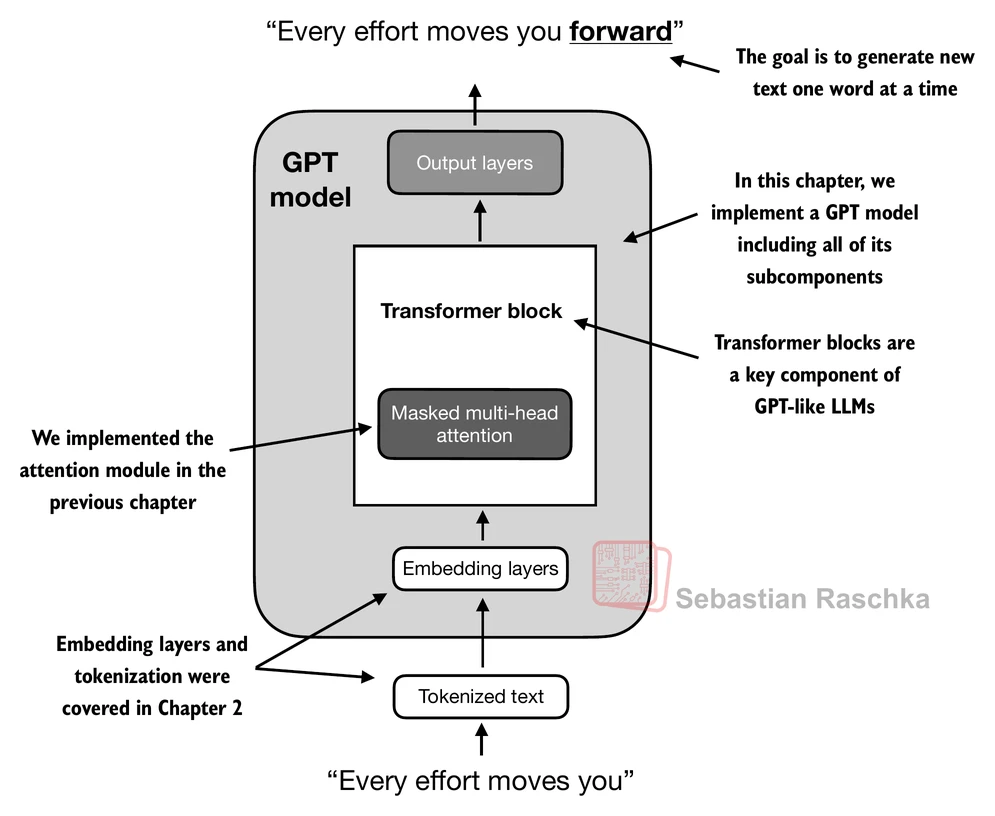

In [2]:
# Firstly, we need to specify the configuration of the small GPT-2 model via dictionary
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size -----> as used by the BPE
    "context_length": 1024, # Context length ----> max number of input tokens the model can handle
    "emb_dim": 768,         # Embedding dimension ----> each token will be transformed into vector 768-dimension
    "n_heads": 12,          # Number of attention heads ----> how many parallel attention mechanisms
    "n_layers": 12,         # Number of layers ----> how many transformer blocks
    "drop_rate": 0.1,       # Dropout rate ----> regularization technique to prevent overfitting
    "qkv_bias": False       # Query-Key-Value bias ----> determines wheter to include a bias vector in the Linear layers of the multi-head attention for query, key and value computations.
    
}

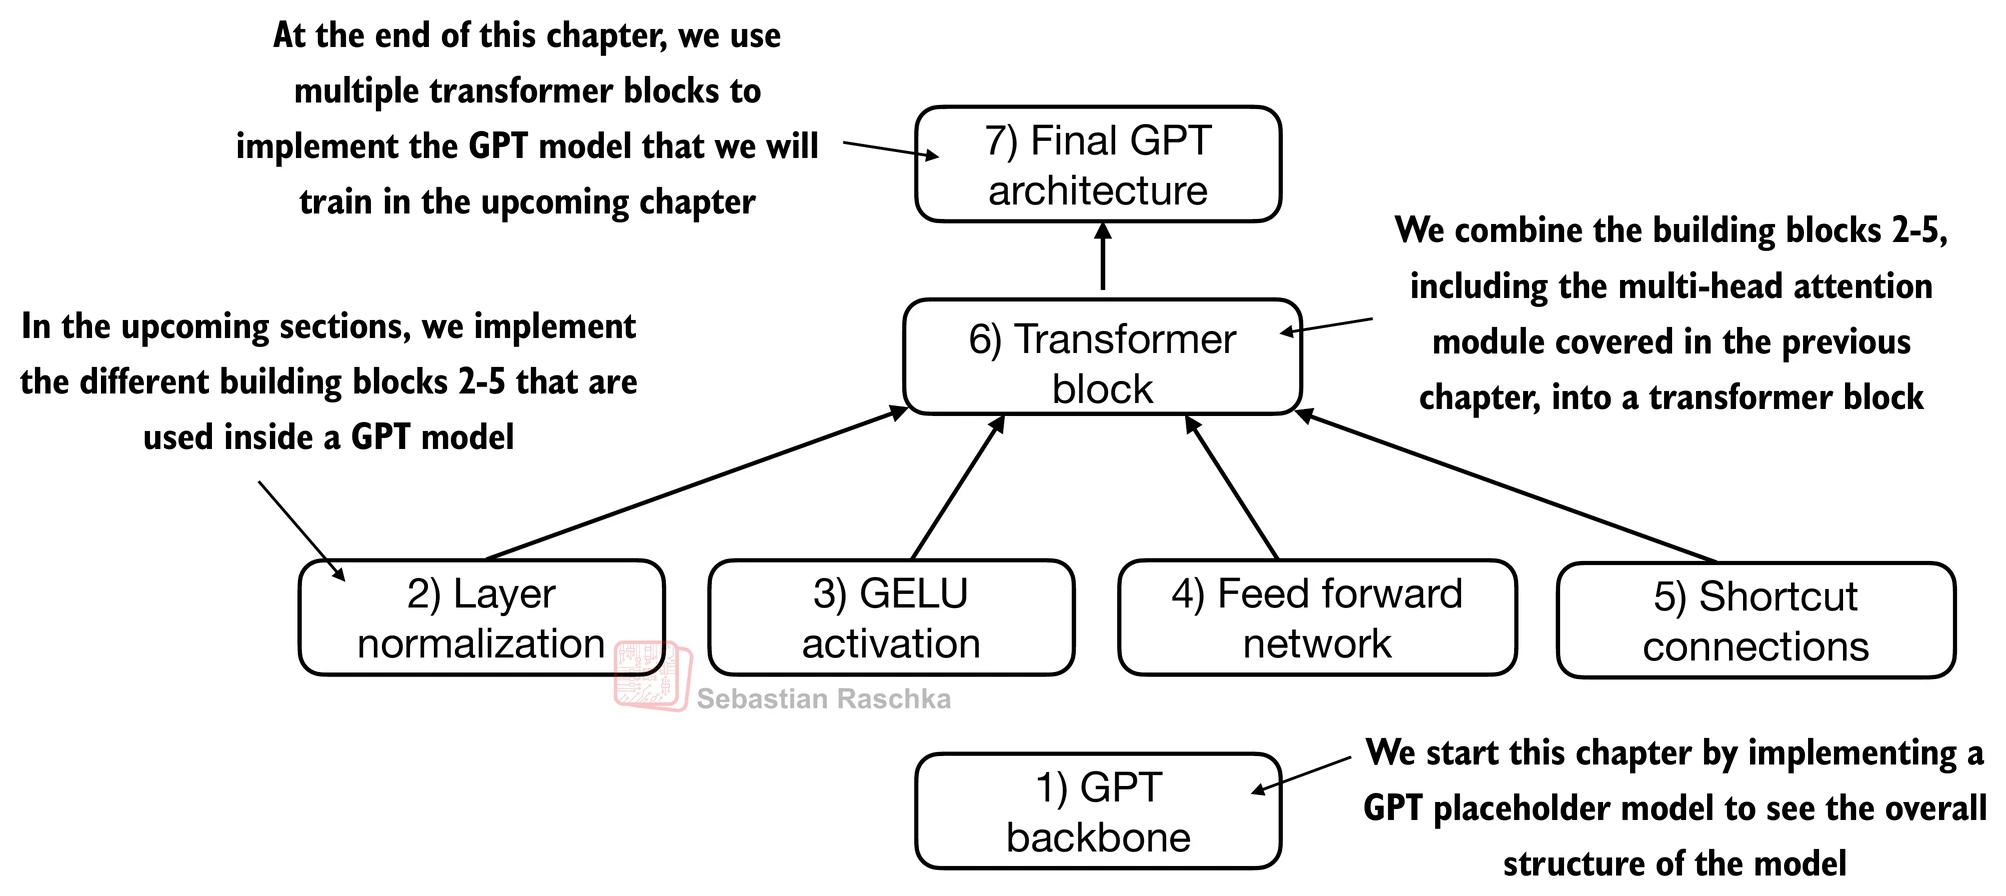

In [3]:
import torch
import torch.nn as nn
# Use this as a placeholder for the full GPT model implementation.

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # Token embedding layer from vocabulary to embedding dimension
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        # Positional embedding layer to encode token positions
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        # Dropout layer for regularization
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        # Output head to project embeddings back to vocabulary size
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        # Extract batch size and sequence length from input indices
        batch_size, seq_len = in_idx.shape
        # Get token embeddings 
        tok_embeds = self.tok_emb(in_idx)
        # Get positional embeddings
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        # Combine token and positional embeddings
        x = tok_embeds + pos_embeds
        # Apply dropout
        x = self.drop_emb(x)
        # Pass through transformer blocks
        x = self.trf_blocks(x)
        # Apply final layer normalization
        x = self.final_norm(x)
        # Project to vocabulary size to get logits, through the logit computation with the linear output layer.
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

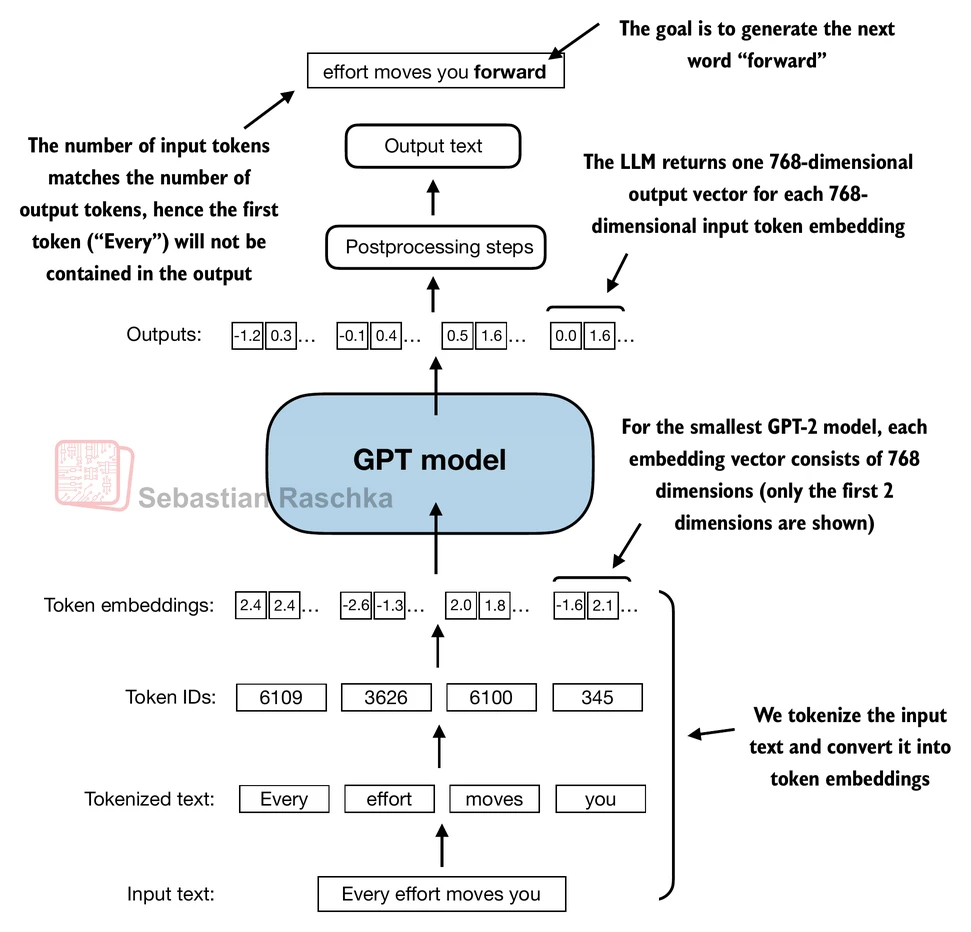

In [4]:
import tiktoken

# Initialize the tokenizer for GPT-2
tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
# Stack the list of tensors into a single tensor along a new dimension (batch dimension)
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

''' 
The output tensor has two rows corresponding to the two text samples.
Each text sample consists of four tokens; each token is a 50 257-dimension vector, which
matches the size of the tokenizer's vocabulary. 
'''

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


#### Normalizing activations with layer normalization

During the training dynamics we can face with the problem know as [*vanishing or exploding gradients*](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).
In other words, the network has difficulty learning the underlying patterns in the data to a degree that would allow it to make accurate predictions or decisions.
**The layer normalization** is able to improve the stability and efficiency of neural network training.
*main concept: adjust the activations (outputs) of neural network layer to have a mean of 0 and a variance of 1 (unit variance)*.

###### *note: often an alternative to layer normalization is the batch normalizzation. This last one normalizes across the batch dimension, while the first one across the feature dimension (it offers a more flexibility and stability in these scenarios. This is adopted in the distributed training or when deploying models in env where resources are limited).*

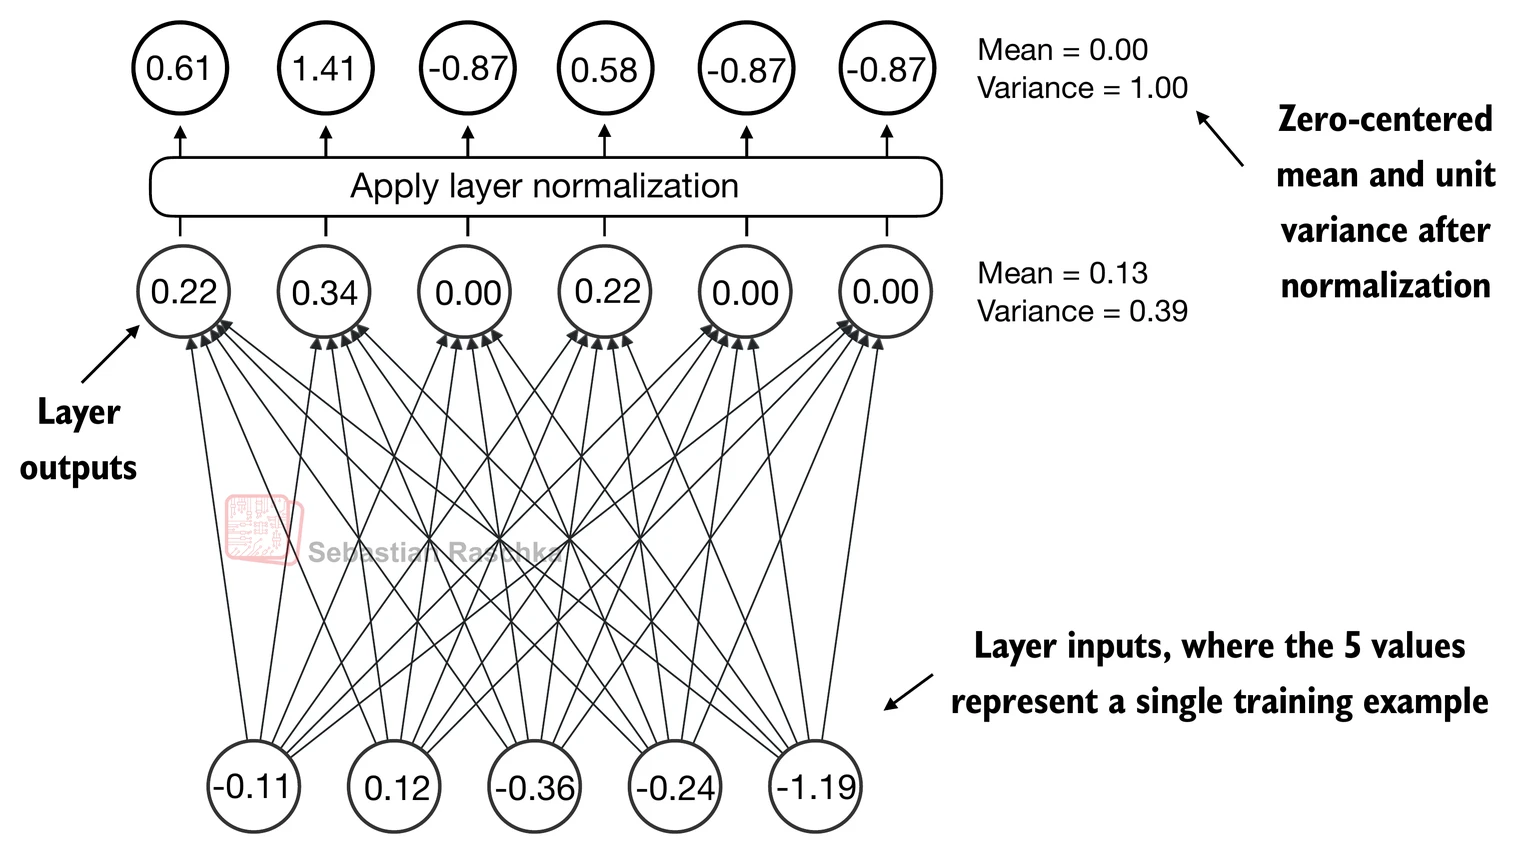

In [24]:
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5) 
print(f"The examples are the following: \n 1. -> {batch_example[0]}, \n 2. -> {batch_example[1]}")

# Now let's reproduce linear layer, then applying an activation function the results become positive.
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

The examples are the following: 
 1. -> tensor([-0.1115,  0.1204, -0.3696, -0.2404, -1.1969]), 
 2. -> tensor([ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085])
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [25]:
# *keepdim parameter* is used to ensuere that the output tensor retains the same number of dimensions as the input tensor.
# *dim parameter* specifies the dimension along which the calculation off the statistic should be performed in a tensor.
#  dim = -1   --->   it refers to the last dimension. 
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


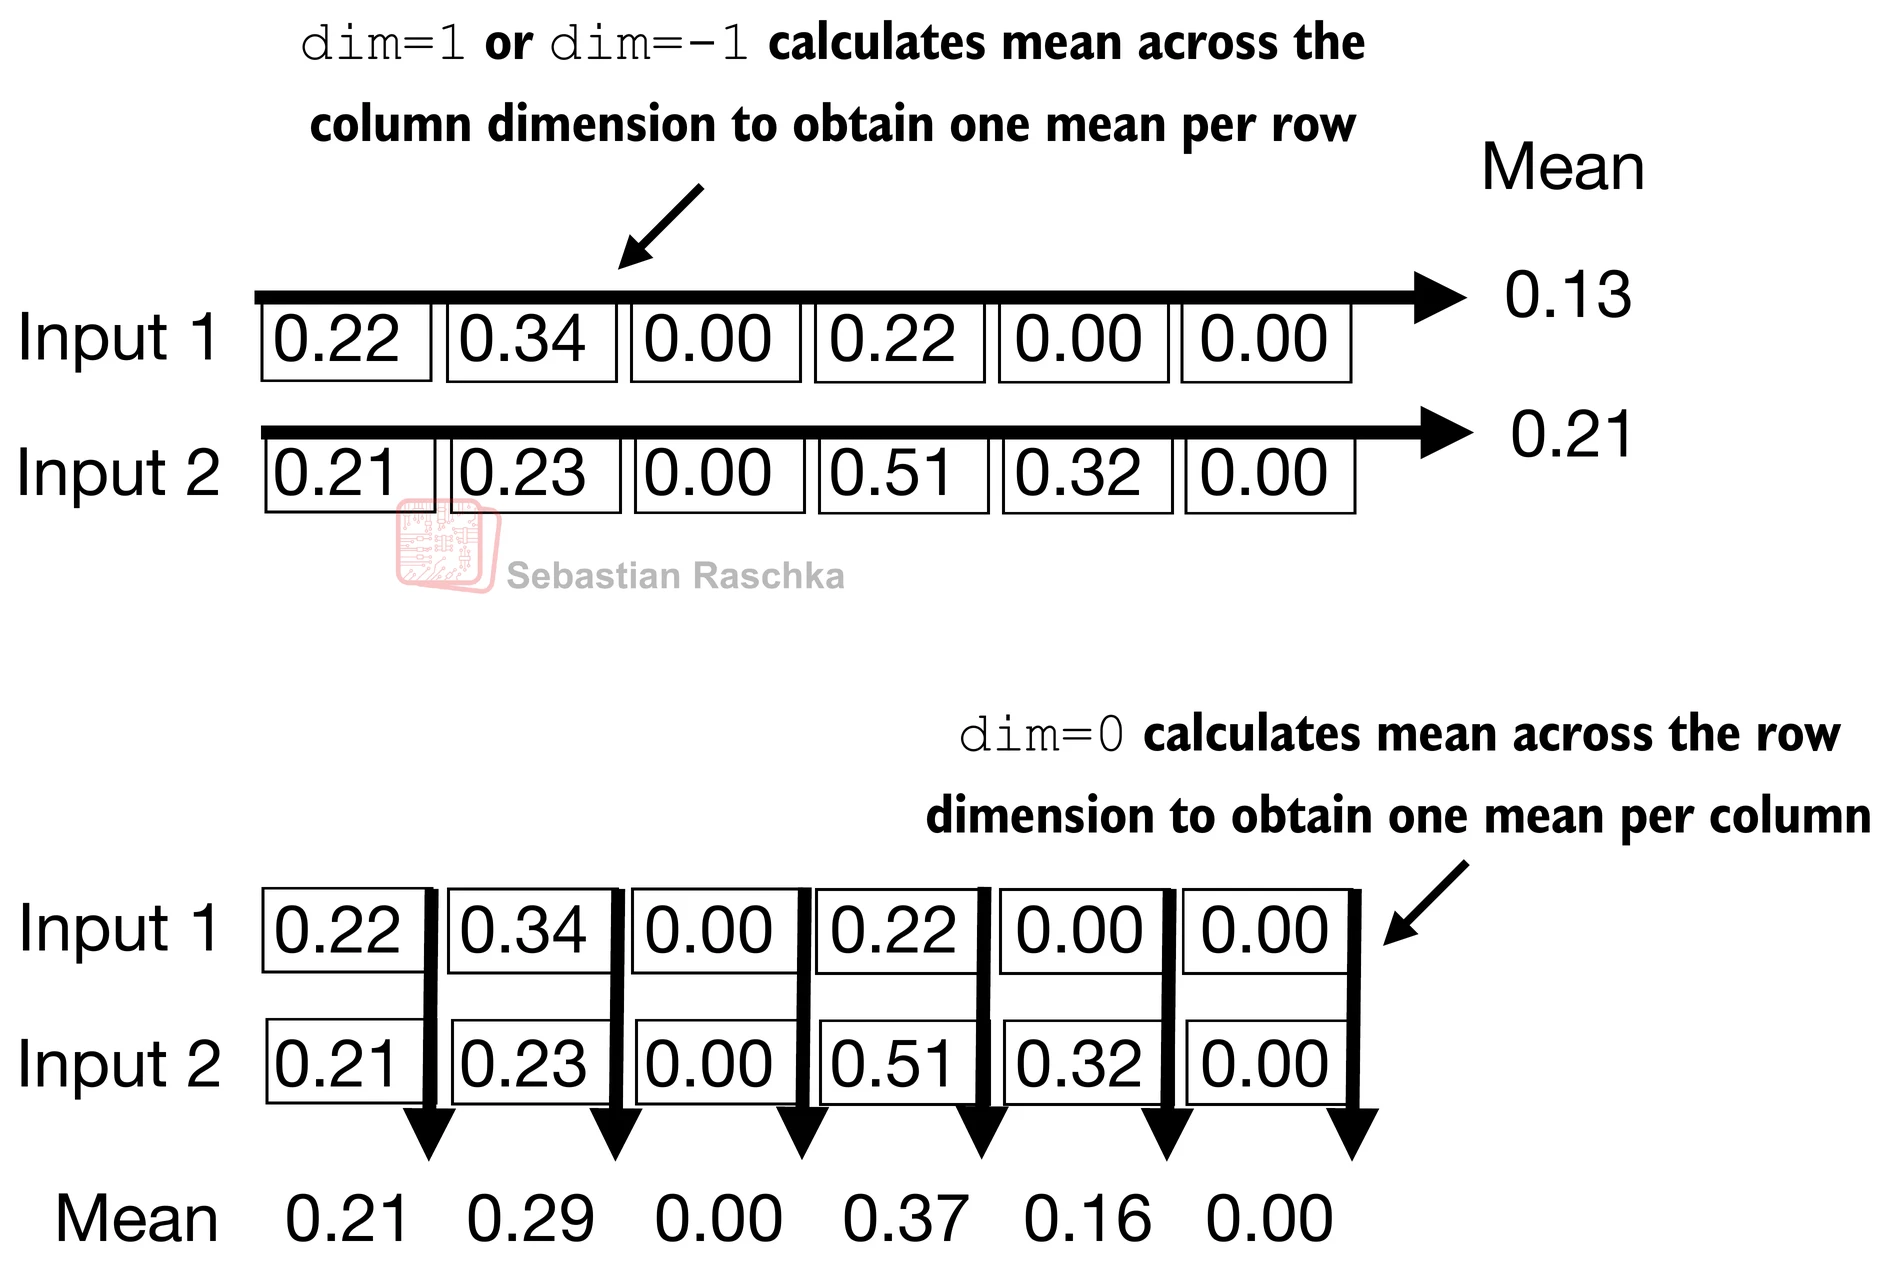

In [26]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [27]:
# To improve readability, we can also turn off the scientific notation.

torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [28]:
# Now encapsulate this process in a PyTorch module

# This layer normalization operates on the last dimension, which represents the embedding dimension (emb_dim)
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        # To prevent division by zero during normalzation
        self.eps = 1e-5

        # These parameters are trainable parameters that LLM adjusts during training phase.
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        '''
        In this implementation we set *unbiased = False* to use this formula: sum_i(x_i - x*)^2 / n to compute variance where n is the sample size.
        This formula doesn't include Bassel's correction (which use n-1), but if n large ---> n = n-1
        Link: https://en.wikipedia.org/wiki/Bessel%27s_correction
        '''
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [29]:
# Let's  try
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("The mean should be 0 after the nromalization :\n", mean)
print("The variance should be 1 after the normalization:\n", var)

The mean should be 0 after the nromalization :
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
The variance should be 1 after the normalization:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


#### GELU activations

GELU (*Gaussian error linear unit*) activation function plays a crucial role in this neural network submodule. Exists other activation function like (simpler) ReLU and SwiGLU (*Swish-gated linear unit*).
GELU and SwiGLU are more complex incorporating Gaussian and sigmooid-gated linear units, respectively.

In [ ]:
# cheap approximation implementation

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

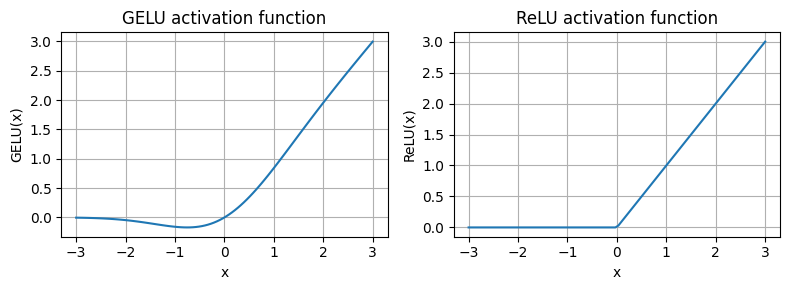

In [32]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

###### Why prefer GELU respect ReLU?
- ReLU is a piecewise linear function that outputs the input directly if it is positive; otherwise, it outputs zero.
- GELU is a smooth, non-linear function that approximates ReLU but with a non-zero gradient for negative values (except at approximately -0.75)

The smoothness can lead to better optimization properties during training. the sharp corner at zero makes optimization harder, especially in complex network.
**During the training process, neurons that receive negative input can still contribute to the learning process.**

#### Feed forward network

In [34]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

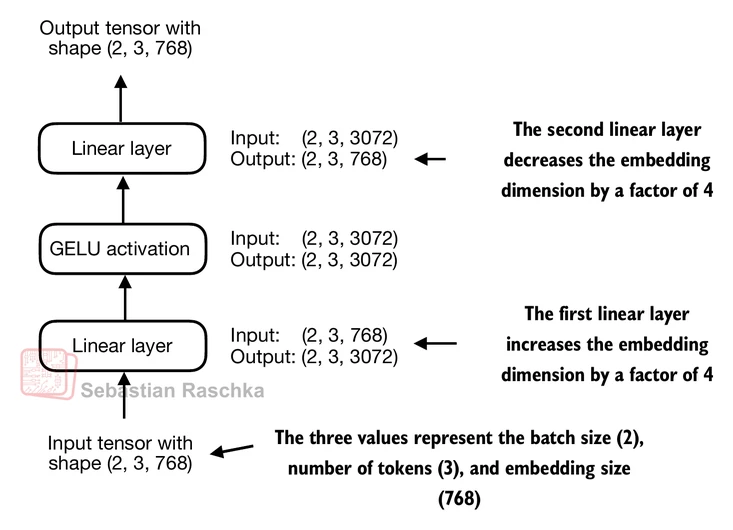

In [35]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape) # output size is the same input size

torch.Size([2, 3, 768])


The *Feed‑Forward* module is a position‑wise two‑layer MLP applied independently to each token embedding.
In practice it projects the embedding x ∈ R^d up to a larger hidden dimension (e.g. 4·d), applies a nonlinearity (GELU, SwiGLU, …) and projects back to d.

*Compact formula: FFN(x) = W2 · act(W1 · x + b1) + b2.*

Why expand then reduce:

- Expansion creates a richer internal representation space where the nonlinearity can form more complex combinations of features.
- Reduction returns the vector to the model dimension so outputs can be added to the residual connection without changing shape.

What it gives the model: Adds per‑token nonlinearity and extra representational capacity that attention (which mixes positions) does not provide. Complements attention by enabling more powerful local transformations for each position.
Stabilized with residual connection + LayerNorm so training remains stable.

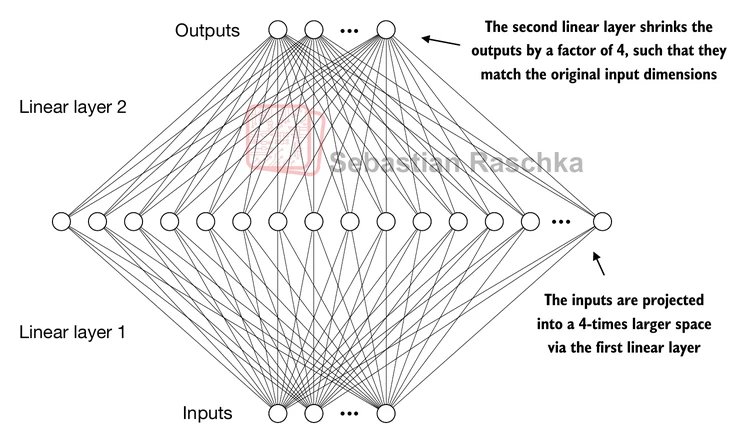

#### Adding short connections

Also known as skip or residual connections, short connections were proposed to mitigate the challange of vanishing gradients. In this problem the gradient (which guide weight updates during training) become progressively smaller as they propagate backward through the layers, making it difficult to effectively train earlier layers.

A shortcut connection creates an alternative shorter path for the gradient to flow through the network
This is achieved by adding the output of one layer to the output of a later layer, usually skipping one or more layers in between. 

Let's illustrate this idea with a small example network:


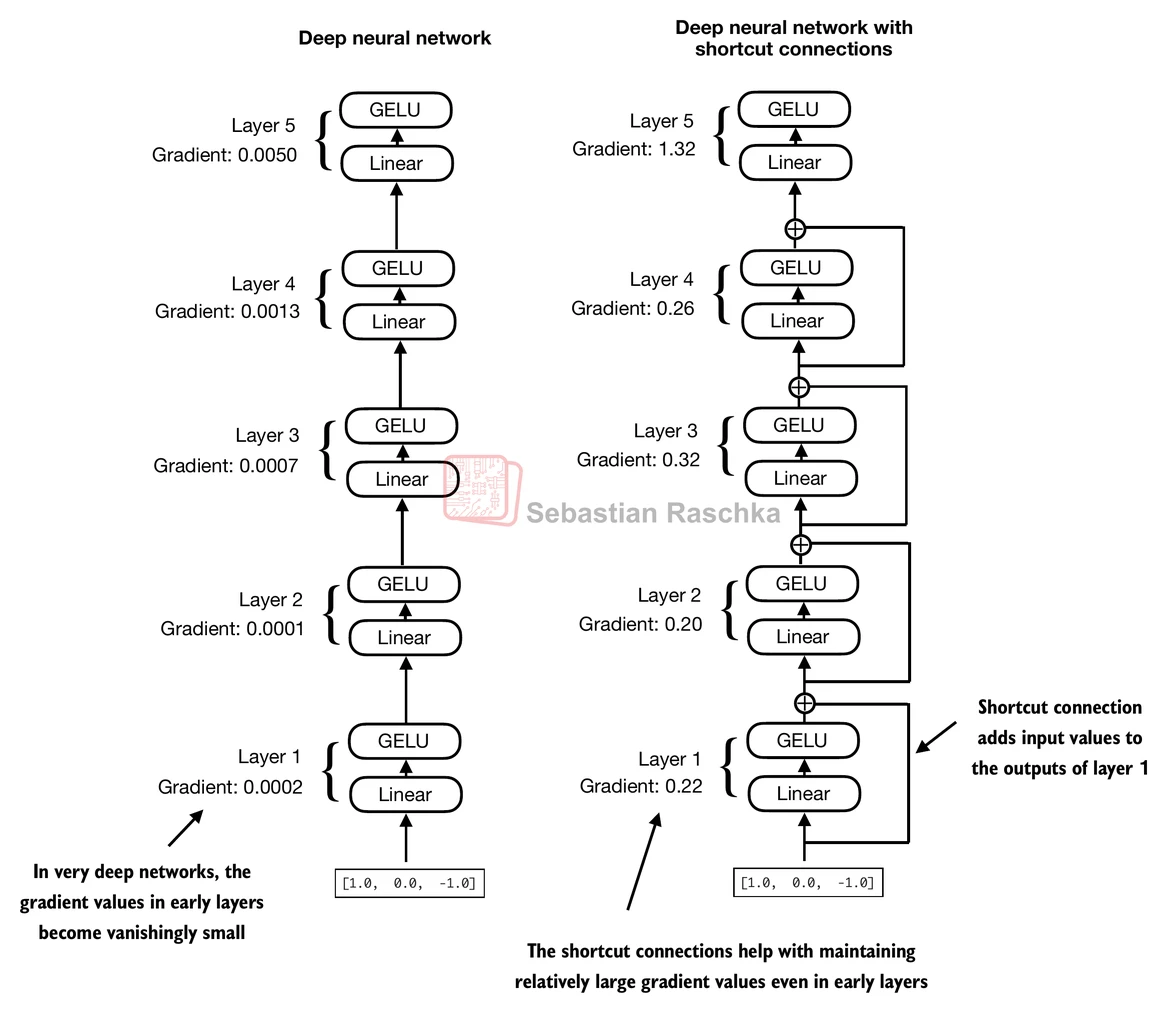


In [42]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            # Sequential is wrap for (Linear Layer + GELU Layer)
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            # five times as in the image above
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [43]:
# Define a function to print the informaiton about gradient  

def print_gradients(model, x):
    # Forward pass to compute the model output for input x
    output = model(x)
    
    # Create a simple target tensor shaped to match the output for loss computation (simplicity zero)
    target = torch.tensor([[0.]])

    # Instantiate the loss function (mean squared error) and compute the scalar loss
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backpropagate to compute gradients for all parameters
    loss.backward()

    # Iterate over named parameters and print mean absolute gradient for weight tensors
    for name, param in model.named_parameters():
        # Filter to show only weight parameters (skip biases or other params)
        if 'weight' in name:
            # param.grad is a tensor of gradients; .abs().mean() gives mean absolute gradient (single gradient value per layer)
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [44]:
# WITHOUT shortcut connections
layer_sizes = [3, 3, 3, 3, 3, 1]  
sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


In [45]:
# WITH shortcut connections
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


###### note: in conclusion, shortcut connections are important for overcoming the limitations posed by the vanishing gradients problem in deep neural networks. They will help facilitate more effective training by ensuring consistent gradient flow across layers.

#### Connecting attention and linear layers in a transformer block

Let's implement the transformer block, which combines the casual multi-head attention module from the previous chapter with the linear layers, the feed forward neural network we implemented previously.


In [46]:
# from previous chapter (just copy and paste)
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads 
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length),diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x) 
        queries = self.W_query(x)
        values = self.W_value(x)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        attn_scores = queries @ keys.transpose(2, 3) 
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) 
        return context_vec


In [48]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

For the graphic rapresentation

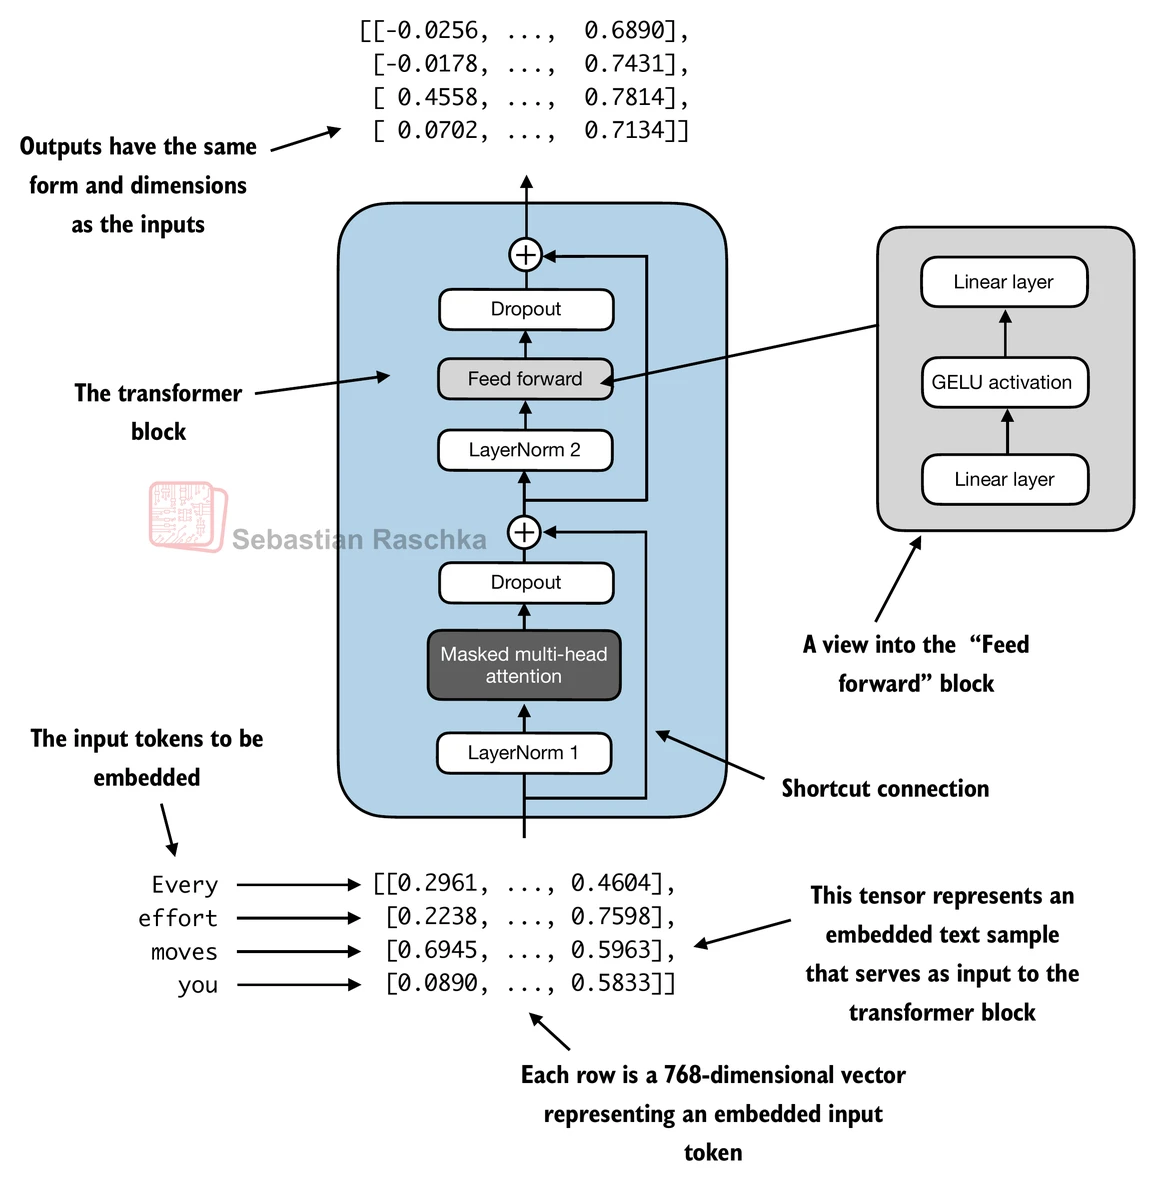

The idea is that the self-attntion mechanism in the multi-head attention block identifies and analyzes relationships between elements in the input sequence. In contrast, the feed forward network modifies the data individually at each position. This combination not only enables a more nuanced understanding and processing of the input but also enhances the model's overall capacity for handling complex data patterns.

In [49]:
# Transformer block preserves the shape throughout the network.
# This aspect is crucial. This design enables application across a wide range of sequence-to-sequence tasks (maintaning a one-to-one relationship). 
torch.manual_seed(123)
x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


#### Coding the GPT model

The transformer block is repeated multiple times; in the case of the smallest 124M GPT-2 model, we repeat it 12 times:

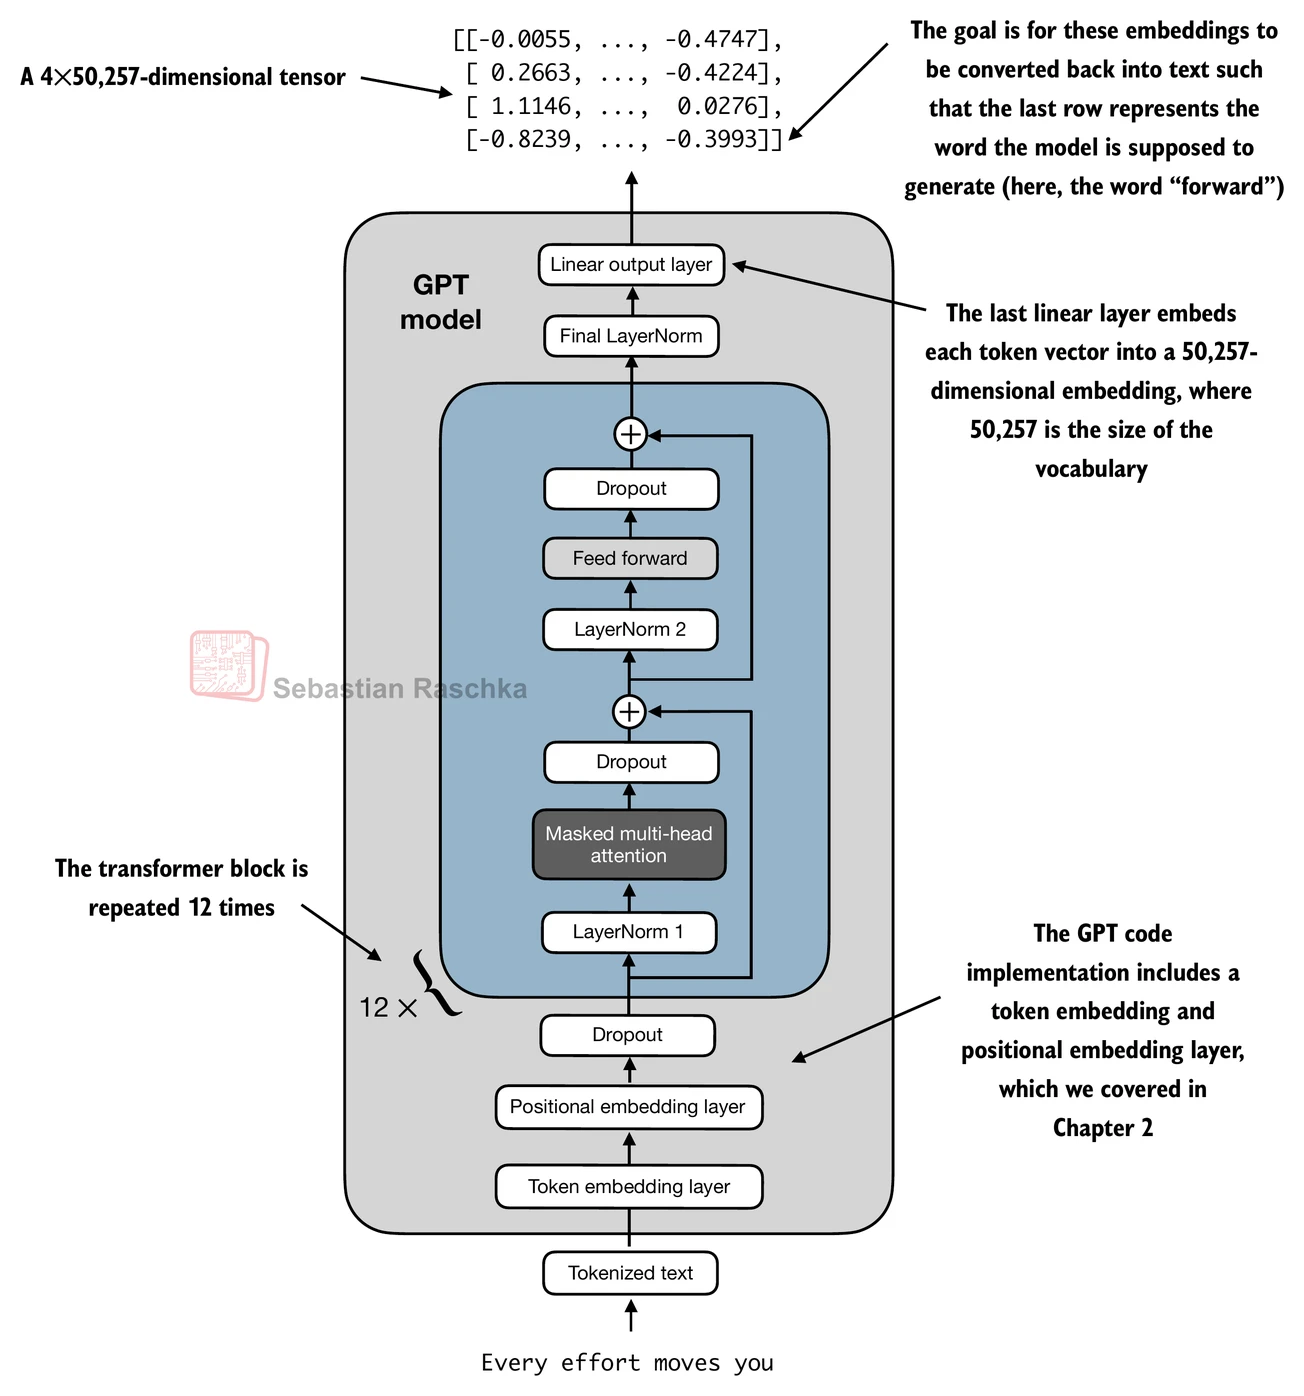

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        # device=in_idx.device ---> depending on which device the input data sits on
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        # LayerNorm layer is applied, standardizing the outputs from the transformer 
        # blocks to stabilize the learning process.
        x = self.final_norm(x)
        # Finally, a linear output head without bias is defined, which projects the 
        # transformer's output into the vocabulary space of the tokenizer to generate 
        # logits for each token in the vocabulary.
        logits = self.out_head(x)
        return logits

In [52]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

# passing batch which is composed by two input texts with four tokens each.
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
# The output made by two (input text), fout (tokens) and 50257 (vocab size).
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [53]:
# numel function is able to collect the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In the original GPT-2 paper, the researchers applied *weight tying*, which means that they reused the token embedding layer (tok_emb) as the output layer, which means setting self.out_head.weight = self.tok_emb.weight.

Weight tyinig reduces the overall memory footprint and computational complexity of the model. 


In [54]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [55]:
# paremeters used twice are not counted.
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [56]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


#### Generating text

LLMs like the GPT model implemented above are used to generate one word at a time.
After the generation of the logits, we need a function *generate_text_simple*, which is a simple and fast method to generate text.
For semplicity, greedy decoding is the easy way to choose teh word (or token) with the highest probability as its next output (the highest logit corresponds to the highest probability,so we technically wouldn't even have to compute the softmax function explicity)

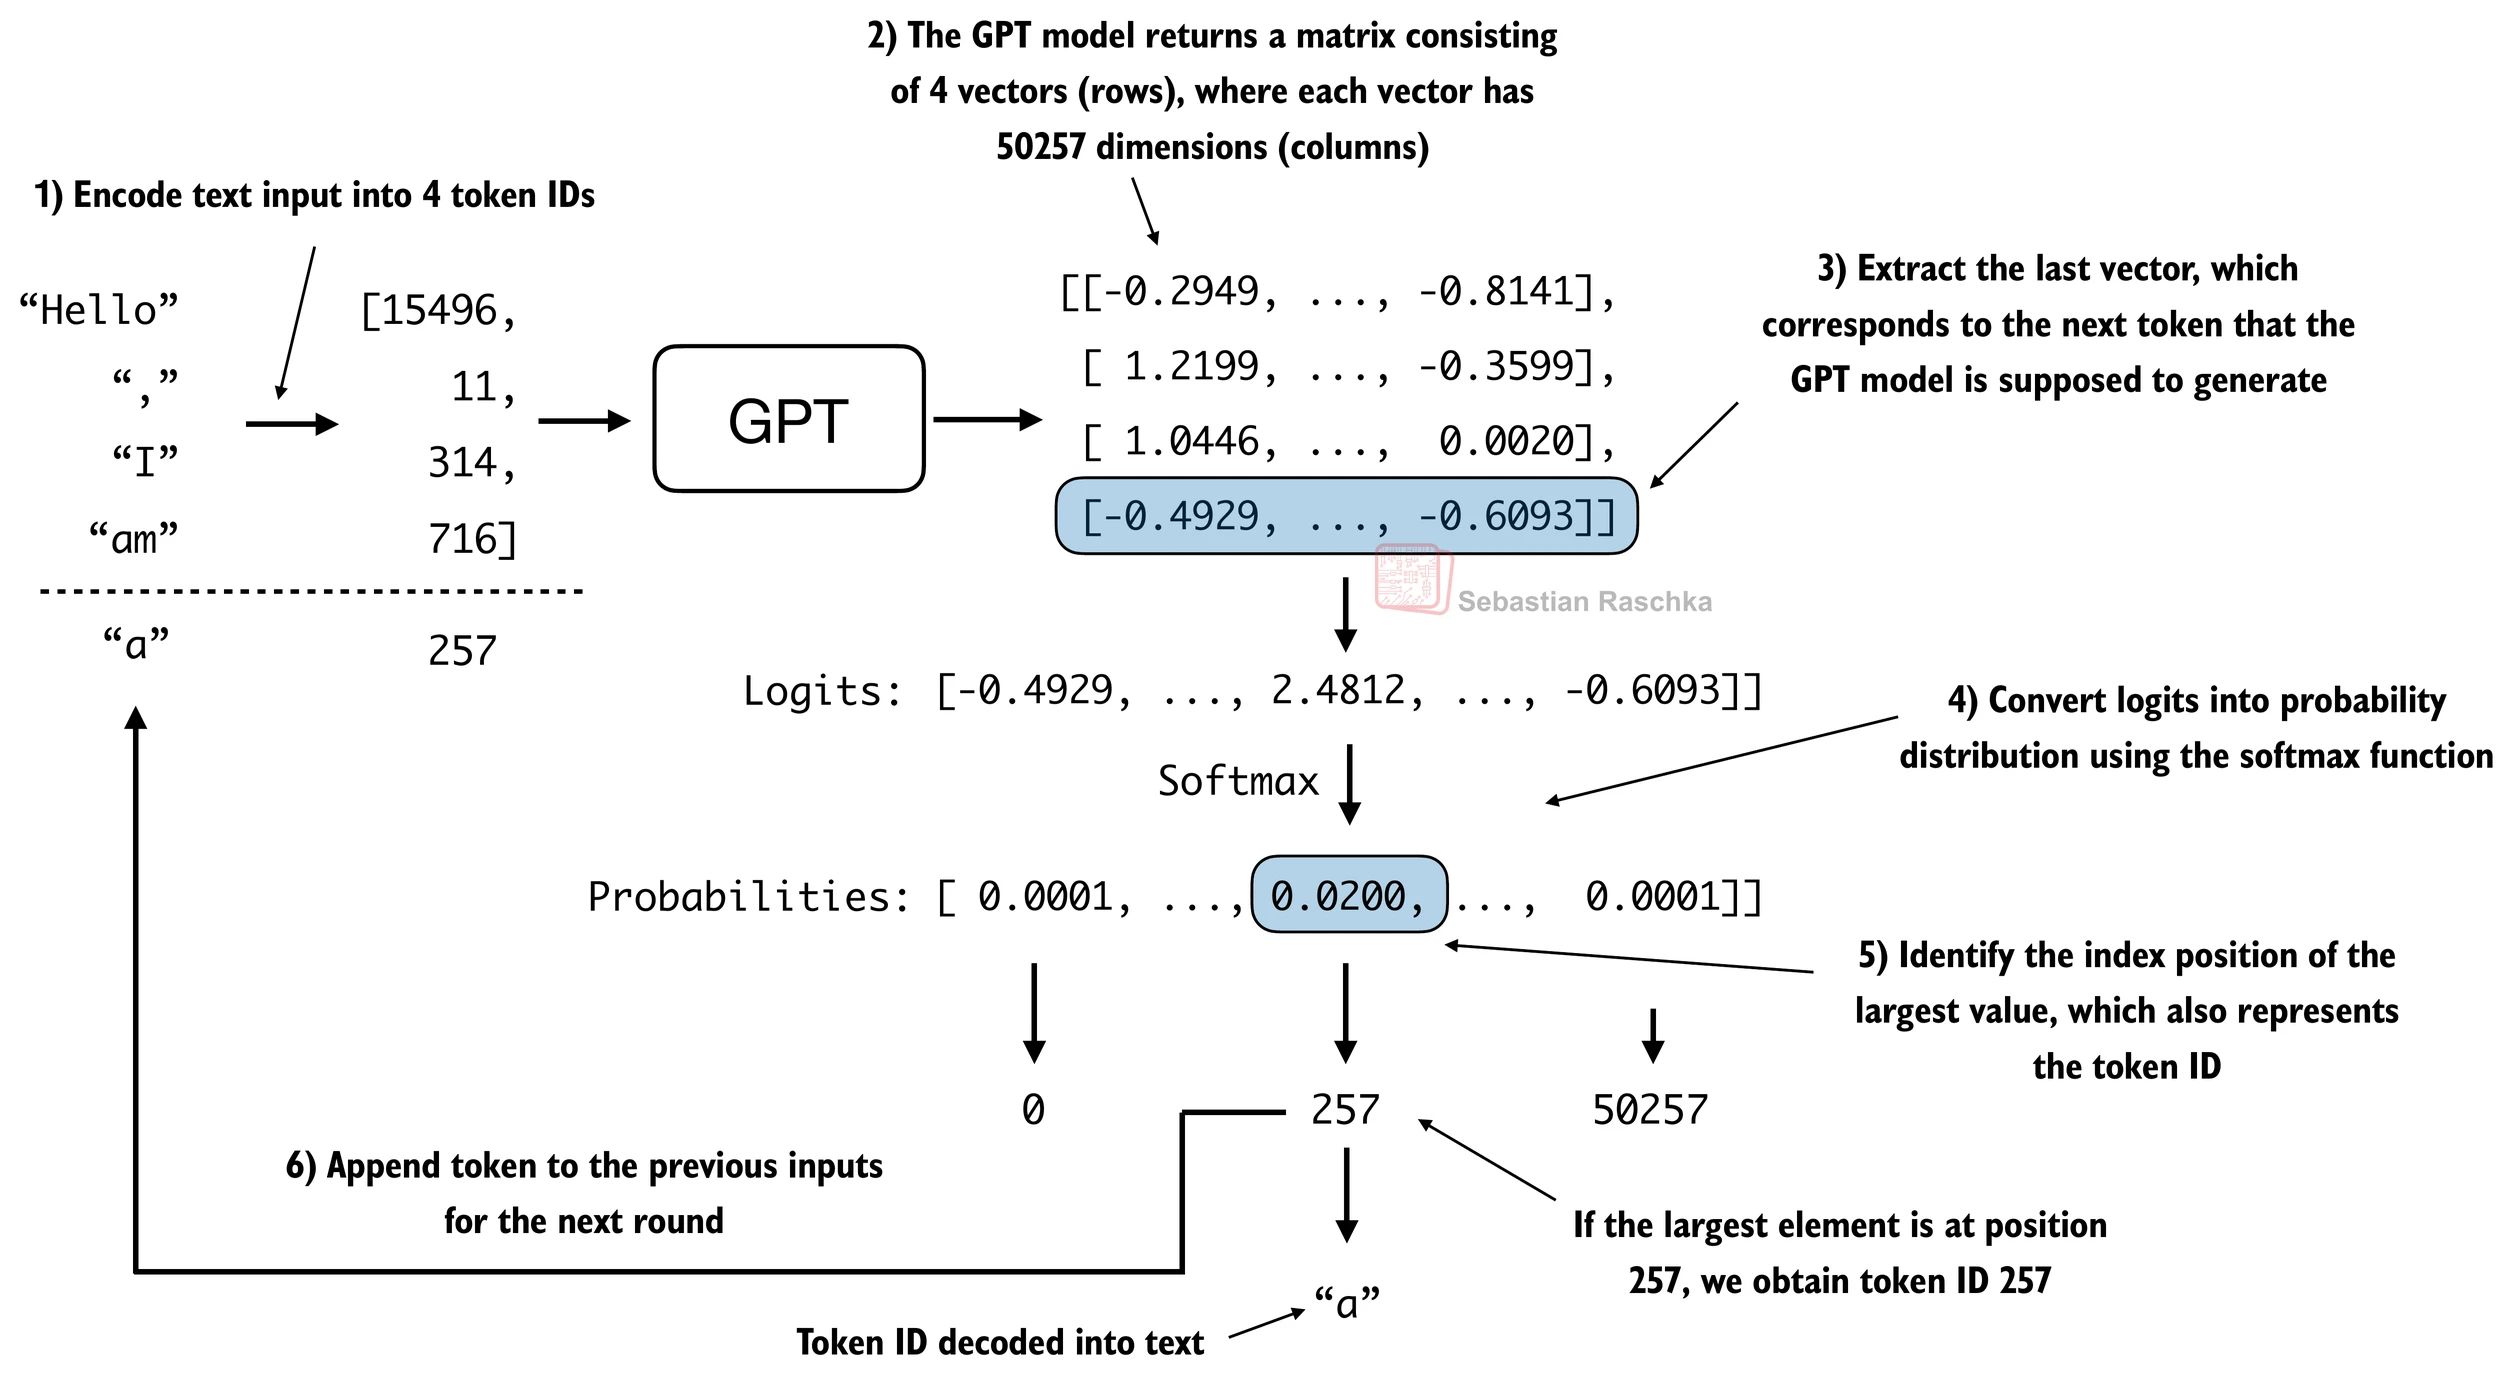

In [67]:
# Greedy Decoding
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

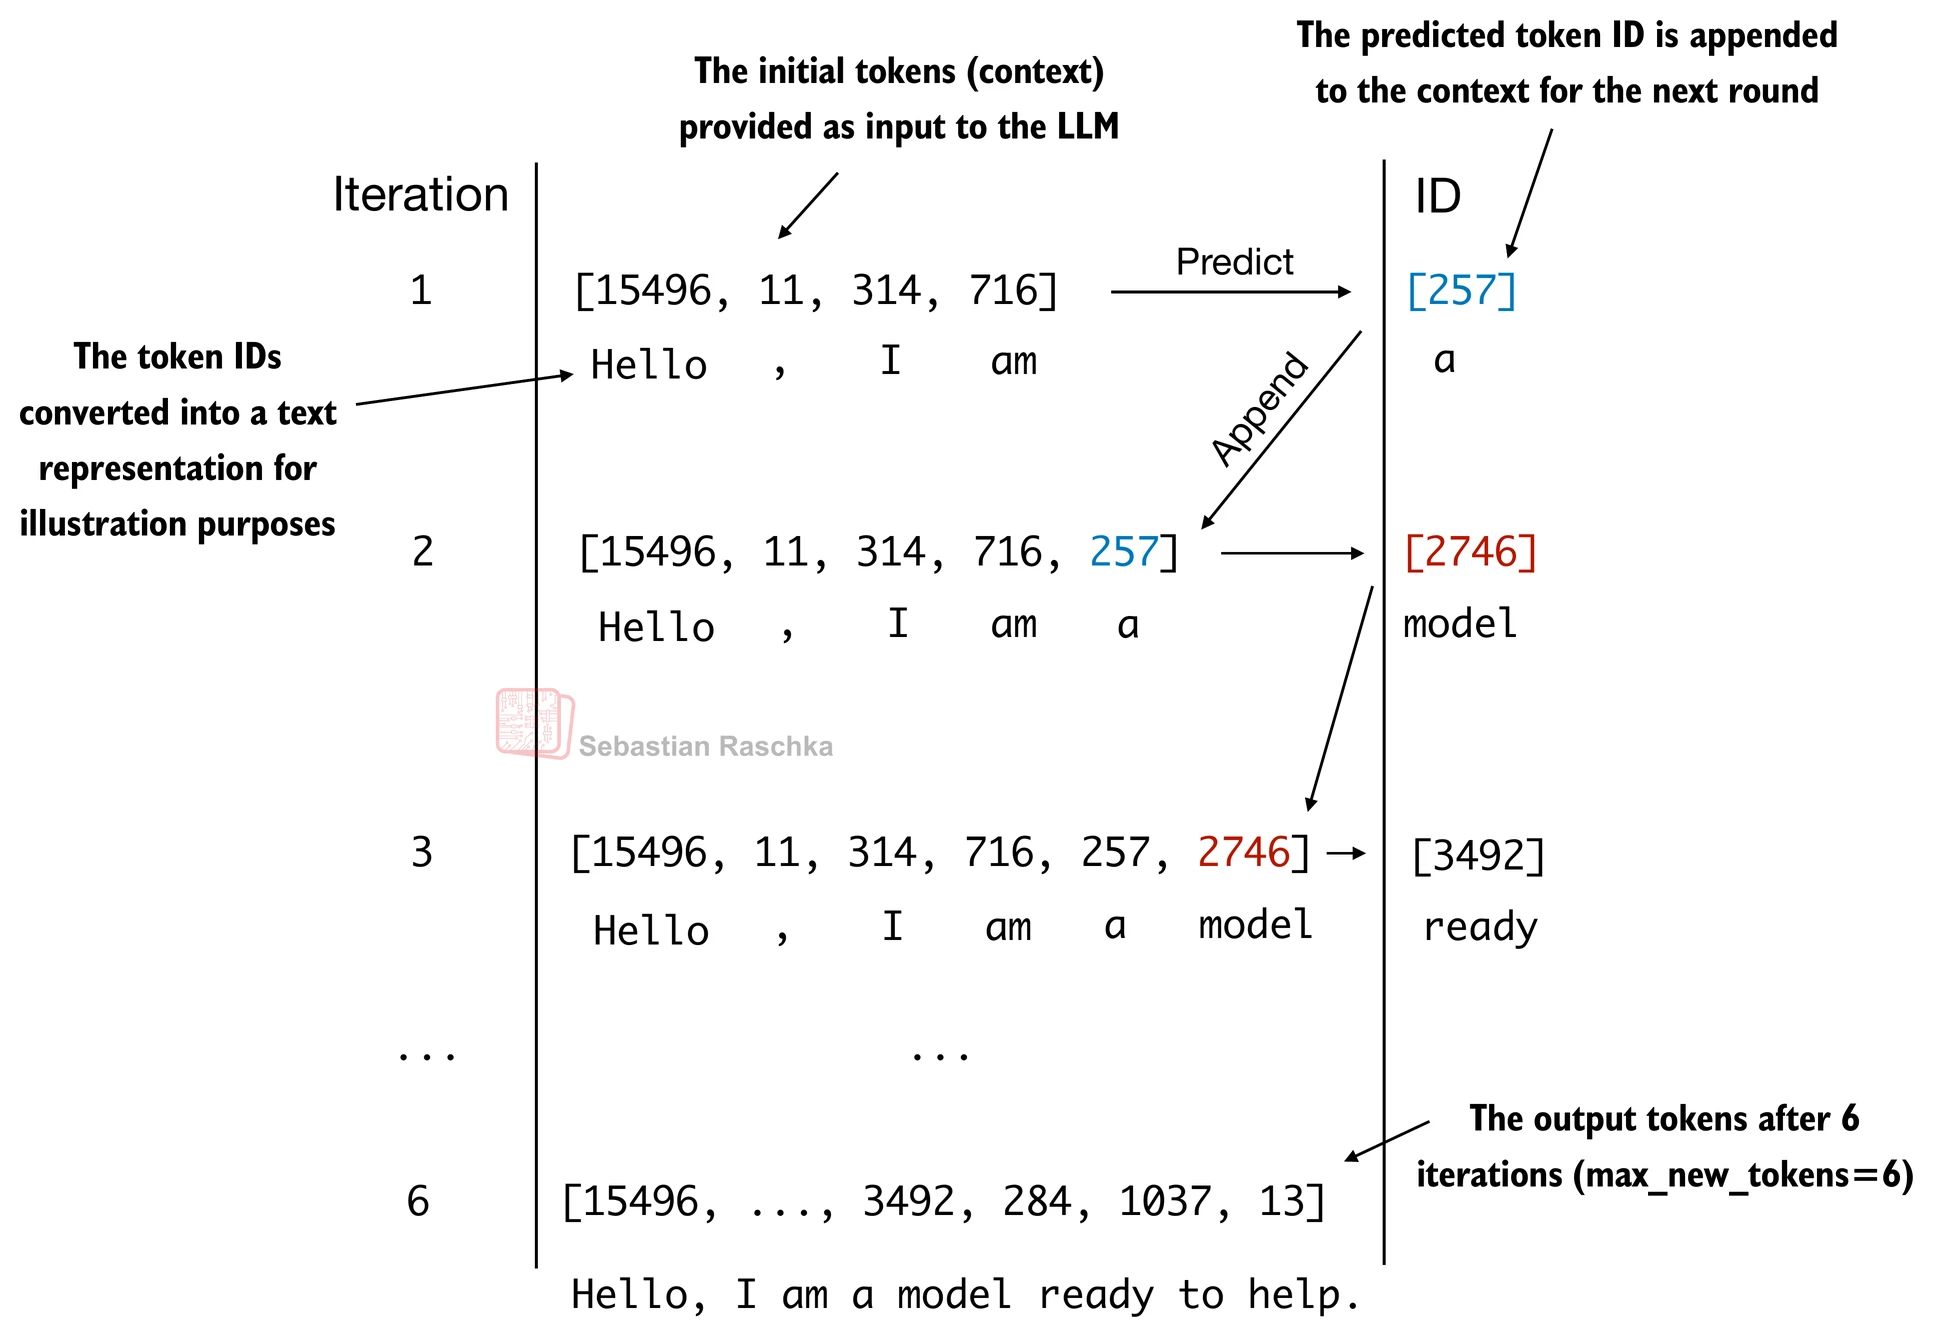

In [68]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
# Adding the batch dimension
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [69]:
model.eval() # disable dropout

# only to check the right implementation, GPT model is instanced with random weights. 
out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    # predict next six tokens
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [70]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)
# obv the model is not trained, so it is speaking randomly, but it speaks :)

Hello, I am Featureiman Byeswickattribute argue
